### Set directory and session info

In [1]:
date = '210415'
larvaID = 'Larva_3'
fov = 'FOV1'
# genoType = 'R57C10-GAL4 x UAS-GCaMP7f'
# sensor = 'GCaMP7f'
imgPath = '/Volumes/genie/Jihong_GENIE_stuff/NMJ_imaging/uf-GCaMP/' + date + '/' + larvaID + '/' + fov
# imgPath = '/Users/zhengj10/Desktop/ufGCaMP/'+ date + '/' + larvaID + '/' + fov


### Import modules

In [2]:
import numpy as np
from read_roi import read_roi_file
from read_roi import read_roi_zip
import tifffile as tff
import matplotlib.pyplot as plt
from matplotlib.path import Path
from glob import glob
from extraction.model import ExtractionModel
import os


### ROI extration

In [3]:
print(os.path.exists(imgPath))
sumPath = imgPath + '/summary/'
roizip = sumPath + 'RoiSet.zip' # roi_1 is background, roi_2-x is ROI
Fiji_rois = read_roi_zip(roizip)


True


In [4]:
rois = []
for key in(Fiji_rois):
    print(key)
    x = Fiji_rois[key]['x']
    y = Fiji_rois[key]['y']
    roi = [x,y]
    rois.append(roi)
    

0029-0046
0023-0066
0049-0068
0088-0060
0103-0051


In [5]:
imgFile = tff.TiffFile(sumPath + 'meanOfImg_020Hz.tif')
imgFile = imgFile.asarray()
ref = np.mean(imgFile,axis=0)
ref.shape


(128, 128)

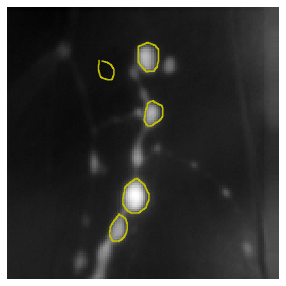

In [6]:
vmin = np.min(ref)
vmax = np.max(ref)
plt.figure(figsize=[5,5])
plt.imshow(ref,cmap='gray',vmin=vmin,vmax=vmax)
for roi in rois:
    plt.plot(roi[0],roi[1],color='y')
# plt.savefig('/Users/zhengj10/Desktop/ROI_pb_cell_edge.png')
plt.axis('off')
plt.show()


In [7]:
rois_coordinates = []
for roi in rois:
    roi_coordinates = np.array([roi[1],roi[0]]) # To match X,Y with image
    roi_coordinates = roi_coordinates.transpose()
    print(roi_coordinates.shape)
    rois_coordinates.append(roi_coordinates)


(116, 2)
(175, 2)
(157, 2)
(217, 2)
(156, 2)


In [8]:
image_coordinates = []
for r in range(ref.shape[0]):
    for c in range(ref.shape[1]):
        image_coordinates.append([r,c])

rois = []
for i in range(1,len(rois_coordinates)):
    print(i)
    
    p_roi = Path(rois_coordinates[i])
    ROI = p_roi.contains_points(image_coordinates)
    roi = ROI.reshape(ref.shape)
    rois.append(roi)

p_fb = Path(rois_coordinates[0])
ROI_fb = p_fb.contains_points(image_coordinates)
fb = ROI_fb.reshape(ref.shape)


1
2
3
4


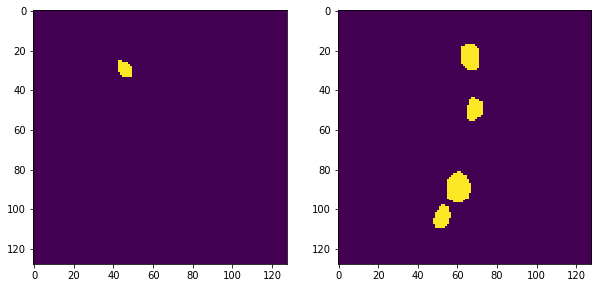

In [9]:
plt.figure(figsize=[10,5])
f_all = np.zeros(fb.shape)
for roi in rois:
    f_all += roi
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(fb)
ax2.imshow(f_all)
# plt.imshow(roi,cmap='gray')
plt.show()


In [10]:
def compute_dFF(imgFile,rois,fb):
    raw_all_rois = []
    dFF_all_rois = []
    for roi_no in range(len(rois)):
        raw_single_roi = []
        dFF_single_roi = []
        for frame in range(imgFile.shape[0]):
            F = np.sum(rois[roi_no]*imgFile[frame,:,:])/np.sum(rois[roi_no])
            raw_single_roi.append(F)
        raw_all_rois.append(raw_single_roi)
        f0 = np.mean(raw_single_roi[250:350])
        f_b = np.sum(fb*np.mean(imgFile[250:350,:,:],axis=0))/np.sum(fb)
#         print(f0)
#         print(f_b)
        dFF_single_roi = (np.array(raw_single_roi)-f0)/(f0-f_b)
        dFF_all_rois.append(dFF_single_roi)
#         print(f0,f_b)
    return dFF_all_rois,raw_all_rois,f0


### Reshape data format

In [11]:
imgFiles = glob(sumPath + '/*.tif')
imgFiles = sorted(imgFiles)

raw_AllTrials_ROIs = []
f0_AllTrials_ROIs = []
dFF_AllTrials_ROIs = []
for trialNum in range(len(imgFiles)):
    imgFile = tff.TiffFile(imgFiles[trialNum])
    imgFile = imgFile.asarray()
    dFF_all_rois,raw_all_rois,f0 = compute_dFF(imgFile,rois,fb)
    
    raw_AllTrials_ROIs.append(raw_all_rois)
    f0_AllTrials_ROIs.append(f0)
    dFF_AllTrials_ROIs.append(dFF_all_rois)
print ('Raw traces stored in list')
print ('Dff traces stored in list')
raw_AllTrials_ROIs_asArray = np.array(raw_AllTrials_ROIs)
dFF_AllTrials_ROIs_asArray = np.array(dFF_AllTrials_ROIs)
print (raw_AllTrials_ROIs_asArray.shape)
print (dFF_AllTrials_ROIs_asArray.shape)


Raw traces stored in list
Dff traces stored in list
(9, 4, 1800)
(9, 4, 1800)


### Save traces and ROI coordinates to mat file

In [12]:
import scipy.io as sio

sio.savemat(sumPath + '/' + '_raw.mat', dict(raw=raw_AllTrials_ROIs))
sio.savemat(sumPath + '/' + '_f0.mat', dict(f0=f0_AllTrials_ROIs))
sio.savemat(sumPath + '/' + '_dff.mat', dict(dff=dFF_AllTrials_ROIs))
# scipy.io.savemat(matlabPath + '/' + '_roiCenter.mat', dict(roiCenter=roiCenter))


### dFF & raw for all ROIs & trials

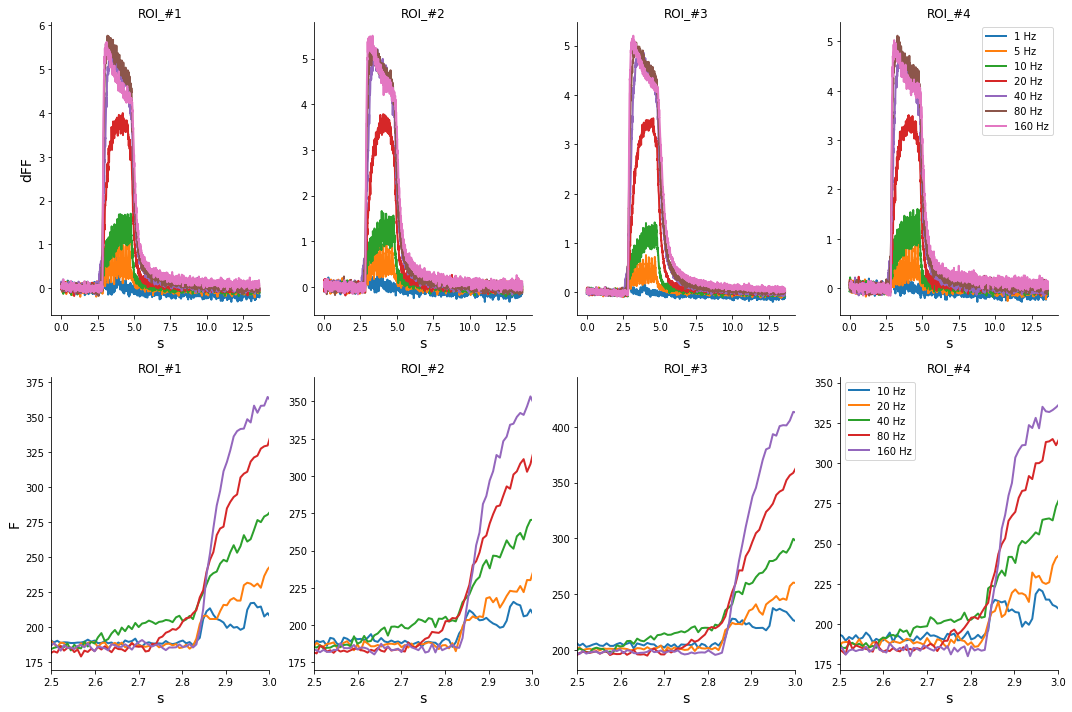

In [17]:
# Single ROI for all trials
trialMap = {
            1: '1 Hz',
            2: '5 Hz',
            3: '10 Hz',
            4: '20 Hz',
            5: '40 Hz',
            6: '80 Hz',
            7: '160 Hz',
            8: '240 Hz',
            9: '320 Hz'
              }


fig = plt.figure(figsize=(15,10))
num_rois = dFF_AllTrials_ROIs_asArray.shape[1]
i=1
for roiNum in range(dFF_AllTrials_ROIs_asArray.shape[1]):
    ax = plt.subplot(2,num_rois,i)
#     for trialNum in range (len(imgFiles)):
    for trialNum in range (7):
        x = np.arange(dFF_AllTrials_ROIs_asArray[trialNum, roiNum, 50:].shape[0])/128.5
        ax.plot(x, dFF_AllTrials_ROIs_asArray[trialNum, roiNum, 50:], lw=2, label=trialMap[trialNum+1])
        if roiNum==0:
            ax.set_ylabel('dFF',size=14)
        if roiNum==dFF_AllTrials_ROIs_asArray.shape[1]-1:
            ax.legend()
    i+=1
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    # ax1.set_title(sensor)
    ax.set_xlabel('s',size=14)
    ax.set_title('ROI_#%d'%(roiNum+1))
#     ax.set_ylim([-0.1,0.5])
#     ax.set_ylim([-0.5,8.75])
#     ax.set_xlim([2.5,3])
    
for roiNum in range(raw_AllTrials_ROIs_asArray.shape[1]):
    ax = plt.subplot(2,num_rois,i)
#     for trialNum in range (len(imgFiles)):
    for trialNum in range (2,7):
        x = np.arange(raw_AllTrials_ROIs_asArray[trialNum, roiNum, 50:].shape[0])/128.5
        ax.plot(x, raw_AllTrials_ROIs_asArray[trialNum, roiNum, 50:], lw=2, label=trialMap[trialNum+1])
        if roiNum==0:
            ax.set_ylabel('F',size=14)
        if roiNum==raw_AllTrials_ROIs_asArray.shape[1]-1:
            ax.legend()
    i+=1
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    # ax1.set_title(sensor)
    ax.set_xlabel('s',size=14)
    ax.set_title('ROI_#%d'%(roiNum+1))
#     ax.set_ylim([-0.1,0.5])
#     ax.set_ylim([-0.5,8.75])
#     ax.set_xlim([3,5])
    ax.set_xlim([2.5,3])
plt.tight_layout()
plt.show()


In [1]:
import os

In [2]:
os.remove('/Volumes/genie/Jihong_GENIE_stuff/patch_attempt_0006_000/Thumbs.db')

OSError: [Errno 16] Resource busy: '/Volumes/genie/Jihong_GENIE_stuff/patch_attempt_0006_000/Thumbs.db'